In [58]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [117]:
from lsst.daf.butlerUtils import ExposureIdInfo

import lsst.afw.display            as afwDisplay
import lsst.daf.base               as dafBase

import lsst.afw.image              as afwImage
import lsst.afw.geom               as afwGeom
import lsst.afw.table              as afwTable

import lsst.meas.algorithms        as measAlg

#### Load the high-level "tasks" that process the pixels

In [60]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate         import CalibrateTask
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask

#### Setup the displays (by default an interface to ds9)
(the _callbacks stuff is working around a bug)

In [61]:
disp  = afwDisplay.Display(1);  disp.callbacks  = disp._callbacks
disp2 = afwDisplay.Display(2);  disp2.callbacks = disp2._callbacks

## Create the tasks

In [102]:
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask =         CharacterizeImageTask(config=config)

sourceDetectionTask =   SourceDetectionTask(schema=schema)

sourceDeblendTask =     SourceDeblendTask(schema=schema)

if False:
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                       algMetadata=algMetadata)
else:
    config = SingleFrameMeasurementTask.ConfigClass()
    config.doApplyApCorr = 'yes'
    config.slots.apFlux = 'base_CircularApertureFlux_12_0'
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config,
                                                       algMetadata=algMetadata)

## Time to process some data

#### Read the input data

In [103]:
fileName = "example1.fits"
exposureIdInfo = ExposureIdInfo(0, 5)

exposure = afwImage.ExposureF(fileName)

#### Create the output table

In [104]:
tab = afwTable.SourceTable.make(schema)

#### Process the pixels

##### Characterise the exposure (e.g. estimate the PSF)

In [105]:
result = charImageTask.characterize(exposure, exposureIdInfo)

##### Detect objects (`sources')

In [106]:
result = sourceDetectionTask.run(tab, exposure)
sources = result.sources

##### Deblend overlapping objects

In [107]:
sourceDeblendTask.run(exposure, sources, exposure.getPsf())

##### Measure the objects' properties

In [108]:
sourceMeasurementTask.run(exposure, sources)

#### Write the results to a FITS file (if desired)

In [109]:
fitsTable = "outputTable.fits"
sources.writeFits(fitsTable)

exposure.writeFits("example1-out.fits")

## OK, we've finished the image processing.

We have our list of sources, but it's not currently continuous in memory

In [110]:
try:
    sources.get("id")
except Exception as e:
    print e


  File "include/lsst/afw/table/BaseColumnView.h", line 205, in static lsst::afw::table::BaseColumnView lsst::afw::table::BaseColumnView::make(const boost::shared_ptr<BaseTable> &, InputIterator, InputIterator) [InputIterator = lsst::afw::table::CatalogIterator<std::__1::__wrap_iter<const boost::shared_ptr<lsst::afw::table::SourceRecord> *> >]
    Record data is not contiguous in memory. {0}
lsst::pex::exceptions::RuntimeError: 'Record data is not contiguous in memory.'



We can fix this with a deep copy

In [111]:
sources = sources.copy(True)

In [112]:
if False:
    sources = afwTable.SourceCatalog.readFits(fitsTable)

## Look at the results

In [113]:
import lsst.afw.display.utils as afwDisplayUtils
import lsst.afw.image.utils as afwImageUtils

Define a boolean array that tells us which objects are 'good'; in this case:
 - No saturated pixels near their centres
 - terminal objects that haven't been further deblended

In [114]:
good = np.logical_and.reduce([sources.get('base_PixelFlags_flag_saturatedCenter') == 0,
                              sources.get("deblend_nChild") == 0,
                              ])

#### Look at how well the aperture photometry agrees with the PSF measurements

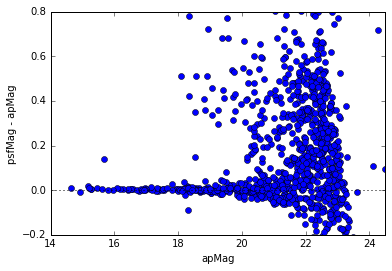

In [116]:
with afwImageUtils.CalibNoThrow():
    if False:
        apMag = exposure.getCalib().getMagnitude(sources["base_CircularApertureFlux_12_0_flux"])
    else:
        apMag = exposure.getCalib().getMagnitude(sources.getApFlux())

    psfMag = exposure.getCalib().getMagnitude(sources.getPsfFlux())

plt.plot(apMag[good], (psfMag - apMag)[good], 'o')

plt.axhline(0.0, ls=':', color='black')
plt.xlim(14, 24.5)
plt.ylim(-0.2, 0.8)

plt.xlabel("apMag")
plt.ylabel("psfMag - apMag")

plt.show()

This doesn't look like modern CCD data as there's no brighter-fatter effect.  That's because we corrected it at the pixel level as part of the instrumental signature effect.

In [97]:
if True:
    disp2.mtv(exposure, title='post calib')
else:
    disp2.erase()

#### Show something about the measurements

In [98]:
with disp2.Buffering():
    for s in sources[good]:
        disp2.dot('+', *s.getCentroid(),
                    ctype=afwDisplay.CYAN if s.get("flags_negative") else afwDisplay.GREEN)

In [99]:
if False:
    radii = algMetadata.get("base_CircularApertureFlux_radii")

    with disp2.Buffering():
        for s in sources[good]:
            for radius in radii:
                disp2.dot('o', *s.getCentroid(), size=radius, ctype=afwDisplay.YELLOW)